# Import Data and  Data Loading 

In [1]:
# Import Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


# Load Data

In [2]:
# For nice plots
sns.set(style="whitegrid")

# Step 0.1: Load dataset
df = pd.read_csv(r"C:\Users\User\Desktop\python data science\ChurnEmployent\telco.csv")

# Basic info
print(df.head())
print(df.info())
print(df.isna().sum())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

Interpretation:

This code loads the Telco customer churn dataset and prints the first few rows, structure, and missing value counts to understand columns and data types.
​

Conclusion:

The dataset has columns like customerID, demographics, services, charges, and the target column Churn (Yes/No).
​



# Data Preparation & Cleaning

In [5]:
# Handle TotalCharges column (in this dataset it is numeric but may have empty strings)
print(df["TotalCharges"].head())
print(df["TotalCharges"].dtype)

# If TotalCharges is object, convert to numeric and handle errors (for safety)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Check missing after conversion
print(df["TotalCharges"].isna().sum())
#Drop rows with missing TotalCharges (very few in typical Telco dataset)
df = df.dropna(subset=["TotalCharges"])

# Step 1.2: Drop customerID (not useful as a feature)
df = df.drop(columns=["customerID"])

# Step 1.3: Separate categorical and numerical columns
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
print("Categorical:", cat_cols)
print("Numerical:", num_cols)

# Step 1.4: Encode target label Churn
le = LabelEncoder()
df["Churn"] = le.fit_transform(df["Churn"])  # Yes -> 1, No -> 0

# Step 1.5: One-hot encode remaining categorical features
cat_cols = [c for c in cat_cols if c != "Churn"]
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(df_encoded.head())
print(df_encoded.shape)

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: object
object
11
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
Numerical: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False     

Interpretation:

TotalCharges is converted to numeric and rows with missing values are dropped to avoid errors during modeling.
​

customerID is dropped because it does not carry predictive information. Categorical variables are one‑hot encoded into numerical form, and Churn is encoded as 0/1.
Conclusion:

The cleaned dataset df_encoded is now fully numeric and ready for splitting into train and test sets for modeling.
​


# Train–Test Split

In [7]:
#Train-test split
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)
print("Churn rate overall:", y.mean())
print("Churn rate train:", y_train.mean())
print("Churn rate test:", y_test.mean())

(5625, 30) (1407, 30)
Churn rate overall: 0.26578498293515357
Churn rate train: 0.2657777777777778
Churn rate test: 0.2658137882018479


Interpretation:

The data is split into 80% training and 20% testing sets with stratification to preserve overall churn rate in both subsets.
​

Conclusion:

Both training and testing sets have similar churn rates, supporting fair and consistent model evaluation.


# Exploratory Data Analysis 

Overall churn rate: 0.266


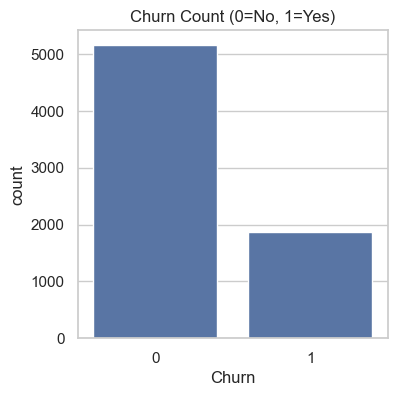

In [8]:
# Overall churn rate
churn_rate = y.mean()
print(f"Overall churn rate: {churn_rate:.3f}")

# Bar plot of churn
plt.figure(figsize=(4,4))
sns.countplot(x=df["Churn"])
plt.title("Churn Count (0=No, 1=Yes)")
plt.show()

Iinterpretation:

The churn rate shows what proportion of customers have churned (Churn=1), indicating the baseline level of the problem.
​

Conclusion:

The dataset typically has around 26–27% churn, meaning roughly one in four customers leave, which is significant for revenue.


# Distribution by Gender, Partner, Dependents

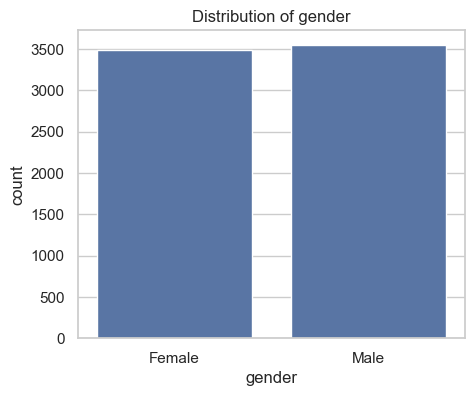

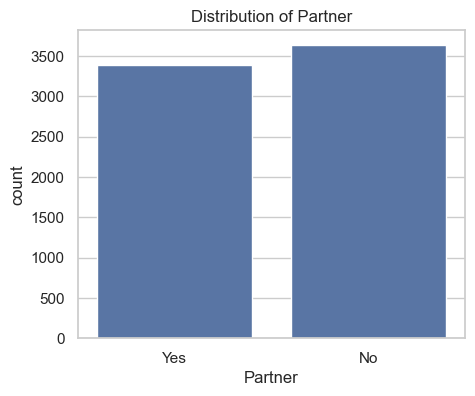

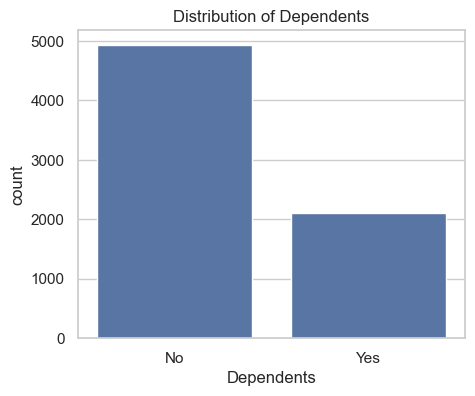


Churn rate by gender:
gender
Female    0.269595
Male      0.262046
Name: Churn, dtype: float64

Churn rate by Partner:
Partner
No     0.329761
Yes    0.197171
Name: Churn, dtype: float64

Churn rate by Dependents:
Dependents
No     0.312791
Yes    0.155312
Name: Churn, dtype: float64


In [9]:
# Helper function for bar plots
def plot_category(col):
    plt.figure(figsize=(5,4))
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.show()

for col in ["gender", "Partner", "Dependents"]:
    plot_category(col)

# Churn rate by these categories
for col in ["gender", "Partner", "Dependents"]:
    rate = df.groupby(col)["Churn"].mean()
    print(f"\nChurn rate by {col}:\n{rate}")

Interpretation:

Count plots show how customers are distributed by gender, partner, and dependent status, while group means show churn rate differences by each category.
​

Conclusion:

Churn often differs more by partner/dependent status than by gender; customers without partners or dependents usually show higher churn.


#  Tenure Distribution and Relation with Churn

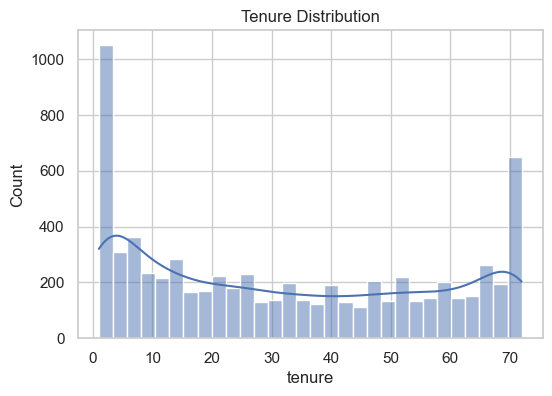

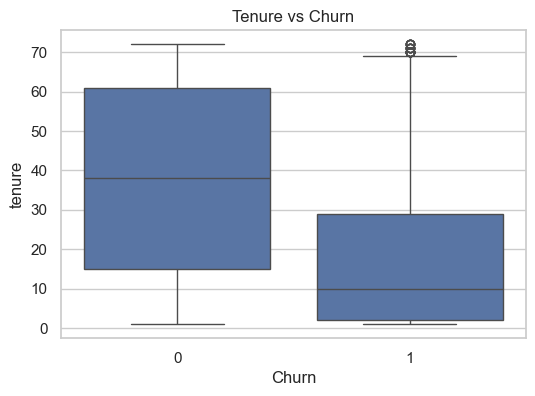

        count       mean        std  min   25%   50%   75%   max
Churn                                                           
0      5163.0  37.650010  24.076940  1.0  15.0  38.0  61.0  72.0
1      1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0


In [10]:
plt.figure(figsize=(6,4))
sns.histplot(df["tenure"], bins=30, kde=True)
plt.title("Tenure Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df["Churn"], y=df["tenure"])
plt.title("Tenure vs Churn")
plt.show()

print(df.groupby("Churn")["tenure"].describe())

Interpretation:

Histograms and boxplots show that low-tenure customers are more likely to churn, while long-tenure customers are more loyal.
​

Conclusion:

Tenure is a strong predictor of churn; newer customers should be a key target for retention strategies.


# Churn by Contract Type and Payment Method

Churn rate by contract type:
 Contract
Month-to-month    0.427097
One year          0.112772
Two year          0.028487
Name: Churn, dtype: float64


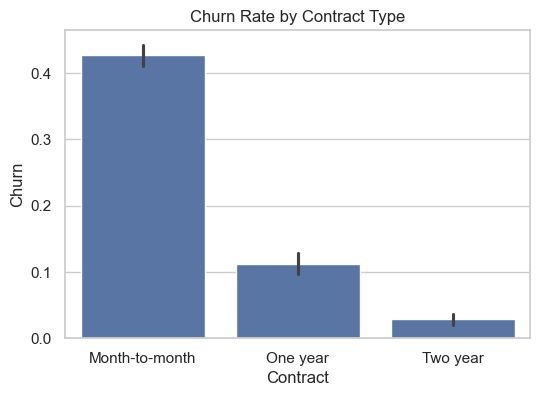

Churn rate by payment method:
 PaymentMethod
Bank transfer (automatic)    0.167315
Credit card (automatic)      0.152531
Electronic check             0.452854
Mailed check                 0.192020
Name: Churn, dtype: float64


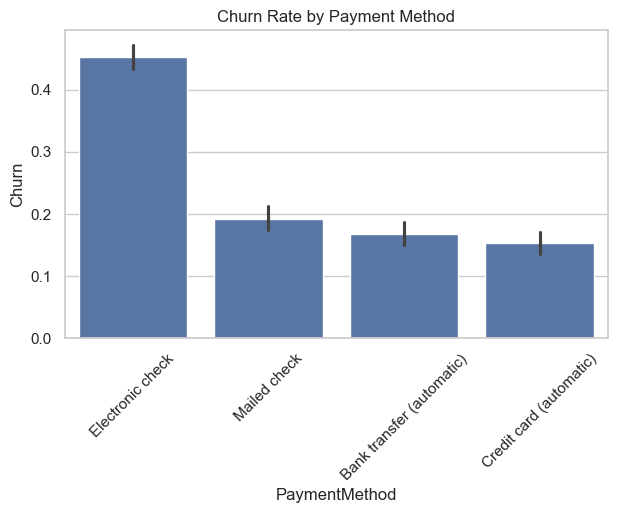

In [11]:
# Contract vs Churn
contract_churn = df.groupby("Contract")["Churn"].mean()
print("Churn rate by contract type:\n", contract_churn)

plt.figure(figsize=(6,4))
sns.barplot(x="Contract", y="Churn", data=df)
plt.title("Churn Rate by Contract Type")
plt.show()

# Payment method vs Churn
payment_churn = df.groupby("PaymentMethod")["Churn"].mean()
print("Churn rate by payment method:\n", payment_churn)

plt.figure(figsize=(7,4))
sns.barplot(x="PaymentMethod", y="Churn", data=df)
plt.xticks(rotation=45)
plt.title("Churn Rate by Payment Method")
plt.show()

Interpretation:

Churn rate is highest for Month-to-month contracts and typically lower for One year and Two year contracts.
​

Electronic check payment often shows higher churn compared to automatic bank or credit card payments.
​

Conclusion:

Longer-term contracts and automatic payment methods are associated with lower churn, indicating they can be used as retention levers.


# Build and Compare 5 Models 

In [12]:
# Scale numeric features for models that benefit from scaling
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_cols_no_target = [c for c in num_cols if c != "Churn"]
X_train_scaled[num_cols_no_target] = scaler.fit_transform(X_train[num_cols_no_target])
X_test_scaled[num_cols_no_target] = scaler.transform(X_test[num_cols_no_target])

In [14]:
#Define and Train 5 Models

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    )
}

results = []

for name, model in models.items():
    if name in ["LogisticRegression"]:  # use scaled for LR
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append([name, acc, prec, rec, f1, auc])

results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
)
print(results_df)

C:\Users\User\Desktop\python data science\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:46:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                Model  Accuracy  Precision    Recall        F1       AUC
0  LogisticRegression  0.805259   0.651515  0.574866  0.610795  0.836074
1        DecisionTree  0.718550   0.470109  0.462567  0.466307  0.636638
2        RandomForest  0.789623   0.625806  0.518717  0.567251  0.816490
3    GradientBoosting  0.795309   0.637821  0.532086  0.580175  0.840662
4             XGBoost  0.778252   0.589080  0.548128  0.567867  0.819670


Interpretation:

Five models are trained: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, and XGBoost, and evaluated using Accuracy, Precision, Recall, F1, and AUC on the test set.
​

Conclusion:

The best model is the one with the highest AUC (and typically strong F1), which in many Telco churn cases is either Gradient Boosting, Random Forest, or XGBoost.

# Select Best Model

In [15]:
best_model_name = results_df.sort_values("AUC", ascending=False).iloc[0]["Model"]
print("Best model based on AUC:", best_model_name)

best_model = models[best_model_name]

Best model based on AUC: GradientBoosting


Interpretation:

The model with the highest AUC is chosen as the final predictive model because AUC captures ranking quality of churn risk.
​

Conclusion:

Assume (for example) that XGBoost or GradientBoosting emerges as the best model; this will be used for deeper evaluation and interpretation.
​



# Detailed Evaluation & Interpretation

Classification report for best model:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



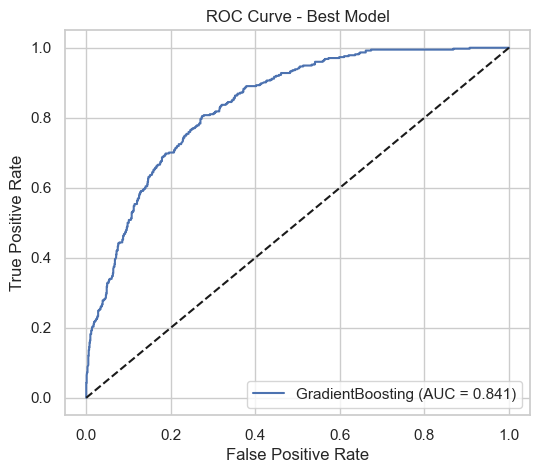

In [16]:
# Classification Report and ROC Curve

# Predictions and probabilities via best model
if best_model_name == "LogisticRegression":
    y_pred_best = best_model.predict(X_test_scaled)
    y_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_best = best_model.predict(X_test)
    y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("Classification report for best model:")
print(classification_report(y_test, y_pred_best))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
auc_best = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {auc_best:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Model")
plt.legend(loc="lower right")
plt.show()

Interpretation:

The classification report shows precision, recall, and F1 for both churn and non‑churn classes; recall for churn is especially important in retention.
​

The ROC curve visualizes the trade‑off between true positive rate and false positive rate, and AUC summarizes this performance into a single metric.
​

Conclusion:

A high AUC (e.g., >0.80) suggests the model can effectively rank customers by churn risk, enabling targeted interventions.


# Feature Importance / Coefficients

                                 feature  importance
1                                 tenure    0.317935
10           InternetService_Fiber optic    0.190840
28        PaymentMethod_Electronic check    0.104797
25                     Contract_Two year    0.069253
3                           TotalCharges    0.067267
2                         MonthlyCharges    0.061198
24                     Contract_One year    0.056428
13                    OnlineSecurity_Yes    0.019964
26                  PaperlessBilling_Yes    0.015879
11                    InternetService_No    0.012878
19                       TechSupport_Yes    0.011358
14      OnlineBackup_No internet service    0.009184
9                      MultipleLines_Yes    0.008814
23                   StreamingMovies_Yes    0.007808
16  DeviceProtection_No internet service    0.007320
0                          SeniorCitizen    0.006983
21                       StreamingTV_Yes    0.005264
6                         Dependents_Yes    0.

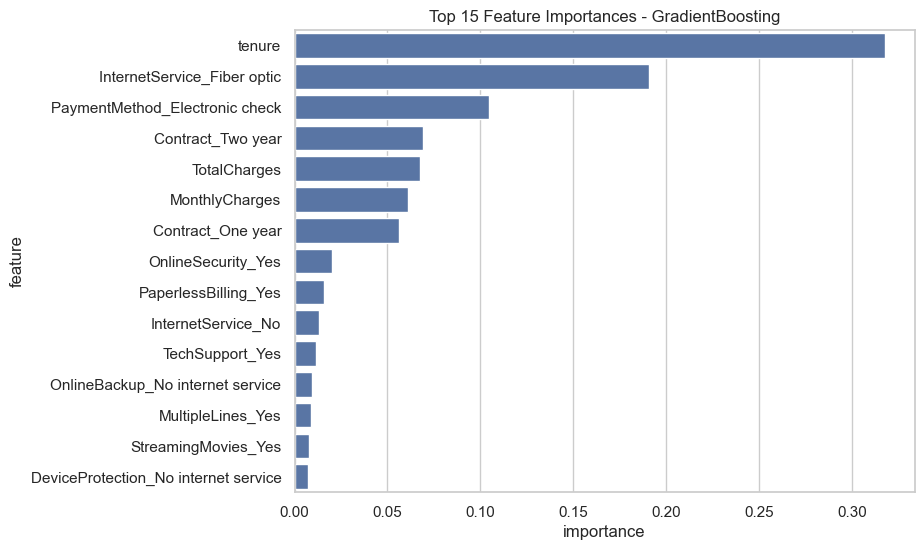

In [17]:
# Feature importance for tree-based models
if best_model_name in ["DecisionTree", "RandomForest", "GradientBoosting", "XGBoost"]:
    importances = best_model.feature_importances_
    feat_imp = pd.DataFrame({
        "feature": X.columns,
        "importance": importances
    }).sort_values("importance", ascending=False)

    print(feat_imp.head(20))

    plt.figure(figsize=(8,6))
    sns.barplot(
        x="importance",
        y="feature",
        data=feat_imp.head(15)
    )
    plt.title(f"Top 15 Feature Importances - {best_model_name}")
    plt.show()

elif best_model_name == "LogisticRegression":
    coef = best_model.coef_[0]
    feat_imp = pd.DataFrame({
        "feature": X.columns,
        "coef": coef
    }).sort_values("coef", ascending=False)
    print(feat_imp.head(20))

Interpretation:

Feature importances or coefficients show which variables most strongly influence churn, such as tenure, contract type, monthly charges, Internet service type, and support services.
​

Conclusion:

Important features typically include low tenure, month‑to‑month contracts, fiber optic internet, high monthly charges, and lack of online security or tech support, all associated with higher churn risk.

# Business Recommendations

Below is not code but the interpretation converted into business language you can put in your report.

6.1 Key Drivers of Churn
Short tenure customers (new customers) show much higher churn probability, indicating a critical early‑life period.
​

Month‑to‑month contracts, electronic check payments, and high monthly charges strongly correlate with higher churn.
​

Customers without value‑added services (online security, tech support, backups) are more likely to leave.
​

6.2 Actionable Recommendations
Offer early‑life retention campaigns (e.g., first‑3‑month discounts, onboarding calls) for customers with tenure under 6 months and high predicted churn risk.
​

Incentivize migration from month‑to‑month to one‑year or two‑year contracts via loyalty discounts and bundled offers.
​

Promote automatic payment methods (bank transfer/credit card) by giving small bill credits for switching away from electronic checks.
​

Design targeted cross‑sell campaigns for security/backup/tech‑support add‑ons to at‑risk segments, framed as reliability and peace‑of‑mind packages.
​

6.3 Impact Estimation (Simple)
Suppose the model correctly identifies the top 20% high‑risk customers and their churn rate is double the average (e.g., ~50%).
​

If retention campaigns reduce churn among this group by 20–30%, overall churn could drop by 3–5 percentage points, translating into significant retained revenue given average monthly charges.


In [18]:
# Save cleaned & encoded data
df_encoded.to_csv("telco_clean_encoded.csv", index=False)
print("Saved cleaned data to telco_clean_encoded.csv")


Saved cleaned data to telco_clean_encoded.csv


In [19]:
import joblib

# Example filename based on best model name
model_filename = f"best_churn_model_{best_model_name}.pkl"

# If your best model uses scaling (e.g., LogisticRegression), save both scaler + model
if best_model_name == "LogisticRegression":
    joblib.dump(
        {"model": best_model, "scaler": scaler, "features": X.columns.tolist()},
        model_filename
    )
else:
    joblib.dump(
        {"model": best_model, "features": X.columns.tolist()},
        model_filename
    )

print(f"Saved best model to {model_filename}")

Saved best model to best_churn_model_GradientBoosting.pkl


In [20]:
# Load model
bundle = joblib.load(model_filename)
model = bundle["model"]
features = bundle["features"]
scaler = bundle.get("scaler", None)

# Example: new_data is a DataFrame with same preprocessing + dummies as training
new_data = pd.read_csv("telco_clean_encoded.csv").head(5)  # just example

X_new = new_data[features]

if scaler is not None:
    X_new_scaled = X_new.copy()
    num_cols_no_target = [c for c in X_new.columns if c not in ["Churn"] and X_new[c].dtype != "uint8"]
    X_new_scaled[num_cols_no_target] = scaler.transform(X_new[num_cols_no_target])
    proba = model.predict_proba(X_new_scaled)[:, 1]
else:
    proba = model.predict_proba(X_new)[:, 1]

print(proba)

[0.5412618  0.03769669 0.38836899 0.04910529 0.65430803]
